# Summarize CMIP6 data withing a polygon

This notebook will demonstrate accessing and summarizing SNAP's CMIP6 holdings for an arbitrary polygon. We will demonstrate spatial and seasonal aggregation (averaging only) of monthly temperature and precipitation projections.

## Polygon: YK Delta

The goal is to spatially average the monthly precipitation and air temperature variables within the polygon.

In [2]:
import requests
import geopandas as gpd
import urllib.parse
import io
import numpy as np

import xarray as xr

import cftime
from

Read in the shapefile to be used for the spatial aggregation and inspect:

In [3]:
yk_gdf = gpd.read_file("YK_domain_YDNWR_plus_ecoregion_akalb83.shp")
yk_gdf.head()

,FID_admndb,NAME,FID_Ecoreg,AREA,PERIMETER,ECOREGFNLA,ECOREGFN_1,DISSOLVE1,COMMONER,LEVEL_1,LEVEL_22,Physiog,Shape_Leng,Shape_Area,geometry
0,-1,None,234,1.408386e+11,2402817.25,0.0,0.0,0,Yukon-Kuskokwim Delta,Polar,Subarctic Taiga,None,151712.726394,4.556084e+08,"POLYGON ((-438135.748 1078513.252, -437883.377..."
1,-1,None,234,1.408386e+11,2402817.25,0.0,0.0,0,Yukon-Kuskokwim Delta,Polar,Subarctic Taiga,None,151712.726394,4.556084e+08,"POLYGON ((-563923.375 1131206.752, -564093.875..."
2,-1,None,234,1.408386e+11,2402817.25,0.0,0.0,0,Yukon-Kuskokwim Delta,Polar,Subarctic Taiga,None,151712.726394,4.556084e+08,"POLYGON ((-556789.372 1133014.252, -556764.624..."
3,-1,None,234,1.408386e+11,2402817.25,0.0,0.0,0,Yukon-Kuskokwim Delta,Polar,Subarctic Taiga,None,151712.726394,4.556084e+08,"POLYGON ((-498630.375 1134280.497, -498595.313..."
4,-1,None,234,1.408386e+11,2402817.25,0.0,0.0,0,Yukon-Kuskokwim Delta,Polar,Subarctic Taiga,None,151712.726394,4.556084e+08,"POLYGON ((-565684.623 1131114.003, -565652.625..."


<Axes: >

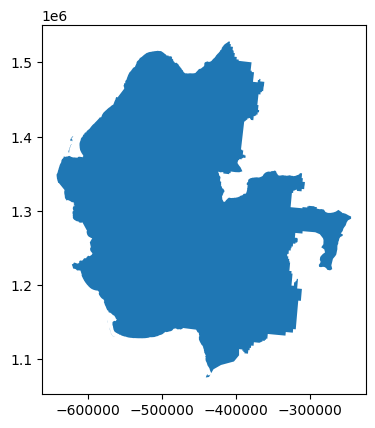

In [4]:
yk_gdf.plot()

There are multiple polygons in this shapefile, and we really just need one for summarization over the coarse ~100km grid of the CMIP6 data, so we'll have to do some prep work. 

We can first simplify the polygon to make it easier to work with, then use the GeoPandas dataframe to do the conversion to WGS84, because we will want the polygon WKT in lat / lon:

<Axes: >

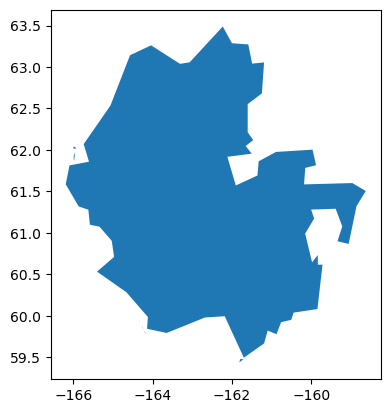

In [5]:
yk_gdf_4326 = yk_gdf.simplify(5000).to_crs(4326)
yk_gdf_4326.plot()

Then we can drop the smaller polygons keeping the main one:

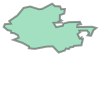

In [6]:
# simplifying the polygon first, because we don't need the fine detail for the coarse grid
yk_poly_4326 = max(yk_gdf_4326.geometry, key=lambda a: a.area)
yk_poly_4326

Now we want the WKT for this polygon:

In [7]:
wkt = str(yk_poly_4326)
wkt

'POLYGON ((-162.6836302045036 59.98074582942932, -163.65001804564585 59.79432082806075, -164.1442253007357 59.844663611537584, -164.12275466468824 59.98660202475141, -164.66256420183146 60.28384889426243, -165.40625076780924 60.5336745689149, -164.97547545031387 60.71073975372692, -165.03465503771562 60.90450088826059, -165.3434878223257 61.07501777495791, -165.5868226031111 61.0993243692258, -165.62518470297388 61.28005128142058, -165.8692408729038 61.31905158575416, -166.1960997291038 61.586277772083186, -166.1003531727906 61.813775498967544, -165.60877615075947 61.85844599696321, -165.74285812335148 62.070395806300155, -165.06908052006864 62.53419503985389, -164.57296020013803 63.14195568912188, -164.0414989299518 63.26108465404154, -163.31415311942928 63.038235543220665, -163.06946000939706 63.05615037850386, -162.23368368842614 63.488372478758386, -162.00179388802755 63.28625368205916, -161.5901822970316 63.27182013597678, -161.49347231085895 63.04081214887458, -161.19178559410395

And finally, we just need to switch the order to lat, lon for the WCPS query:

In [8]:
def flip_str(ll_str):
    lon, lat = ll_str.split(" ")
    return f"{lat} {lon}"


wkt_latlon_str = ", ".join(
    [flip_str(x) for x in wkt.split("((")[1].split("))")[0].split(", ")]
)

Set up some string templates for URL creation.

In [9]:
base_url = "https://zeus.snap.uaf.edu/rasdaman/ows?SERVICE=WCS&VERSION=2.0.1&REQUEST={request_str}"
wcps_base_str = "ProcessCoverages&QUERY={wcps_query}"
base_wcps_url = base_url.format(request_str=wcps_base_str)

Here is the base WCPS query. WCPS stands for web coverage processing service, and it allows the 

>the extraction, processing, and analysis of multi-dimensional coverages

([about WCPS](https://www.ogc.org/standard/wcps/))

It is a language on its own, but this notebook will not dive into details on that. You simply need to know that the below request will average the supplied coverage within the supplied polygon, for all 12 models and all 5 scenarios (1 historical plus 4 projected emissions scenarios). Some, of course, will be null, and we will have to pick those out later. 

In [10]:
wcps_query = """
  for $c in ({cov_id})
    return
    encode(
        coverage timeseries
        over $t t(imageCrsDomain($c[ansi("1980-01-01T12:00:00.000Z":"2100-12-15T12:00:00.000Z")], ansi)), $m model(0:11), $s scenario(0:4)
        values avg(
        clip($c[model($m), scenario($s), ansi($t)], 'POLYGON (({wkt_latlon_str}))')
        ),
        
        "application/netcdf"
    )
)
""".strip().replace(
    "\n", ""
)  # just removing newlines because that's all we need to remove

### Precipitation

Build the request for the precipitation coverage and submit it:

In [11]:
pr_wcps_query = wcps_query.format(
    cov_id="cmip6_monthly_precipitation", wkt_latlon_str=wkt_latlon_str
)
pr_wcps_query = urllib.parse.quote_plus(pr_wcps_query).replace("+", "%20")

url = base_wcps_url.format(wcps_query=pr_wcps_query)
r = requests.get(url)
r

<Response [200]>

Now open the result in a xarray dataset, since we chose netcdf as the result encoding type:

In [146]:
pr_ds = xr.open_dataset(io.BytesIO(r.content))

Unfortunately, the resulting netcdf from the WCPS query has little useful information. The time axis is floats, not even integers. We will need to convert the floats, which are just intervals of length 1, starting at 0.5. 

In [147]:
pr_ds

<xarray.Dataset>
Dimensions:   (t: 1452, model: 12, scenario: 5)
Coordinates:
  * model     (model) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5
  * scenario  (scenario) float64 0.5 1.5 2.5 3.5 4.5
  * t         (t) float64 360.5 361.5 362.5 ... 1.81e+03 1.81e+03 1.812e+03
Data variables:
    band1     (t, model, scenario) float64 ...

We can think of these valuse as "months since 1950-01-01", even if that is not technically true. Doing this is a quick trick to give us a useful monthly time series, though:

In [23]:
ts = cftime.num2date(
    pr_ds.t.values, units="Months since 1950-01-01", calendar="360_day"
)
# rename stuff too
pr_ds = pr_ds.assign_coords(t=ts).rename(t="time", band1="pr")
pr_ds

<xarray.Dataset>
Dimensions:   (time: 1452, model: 12, scenario: 5)
Coordinates:
  * model     (model) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5
  * scenario  (scenario) float64 0.5 1.5 2.5 3.5 4.5
  * time      (time) object 1980-01-16 00:00:00 ... 2100-12-16 00:00:00
Data variables:
    pr        (time, model, scenario) float64 ...

Now we can rename the month and scenario coordinates. 

Normally, we would be able to get these encodings from the coverage itself via a DescribeCoverage request. However, these coverages do not currently have that information at this time. So we will use a manual lookup dict for converting between the integer-valued model/scenario axes and the models/scenarios these values represent. 

In [15]:
model_lu = {
    0: "CESM2",
    1: "CNRM-CM6-1-HR",
    2: "EC-Earth3-Veg",
    3: "GFDL-ESM4",
    4: "HadGEM3-GC31-LL",
    5: "HadGEM3-GC31-MM",
    6: "KACE-1-0-G",
    7: "MIROC6",
    8: "MPI-ESM1-2-HR",
    9: "MRI-ESM2-0",
    10: "NorESM2-MM",
    11: "TaiESM1",
}

scenario_lu = {0: "historical", 1: "ssp126", 2: "ssp245", 3: "ssp370", 4: "ssp585"}
model_encoding_lu = {v: k for k, v in model_lu.items()}
scenario_encoding_lu = {v: k for k, v in scenario_lu.items()}

We will simply "floor" all of the coordinates to get the actual expected dimension encodings (integer valued: for some reason, our current setup with Rasdaman returns netCDFs with +0.5 added to the integer coordinates used to represent the discrete values of irregular (discrete) axes like model and scenario.)

In [16]:
pr_ds = pr_ds.assign_coords(
    model=[model_lu[np.floor(m)] for m in pr_ds.model.values],
    scenario=[scenario_lu[np.floor(s)] for s in pr_ds.scenario.values],
    # also convert the time to a noleap calendar as it will make time-based subsetting easier
).convert_calendar("noleap", align_on="year")
pr_ds

<xarray.Dataset>
Dimensions:   (time: 1452, model: 12, scenario: 5)
Coordinates:
  * model     (model) <U15 'CESM2' 'CNRM-CM6-1-HR' ... 'NorESM2-MM' 'TaiESM1'
  * scenario  (scenario) <U10 'historical' 'ssp126' 'ssp245' 'ssp370' 'ssp585'
  * time      (time) object 1980-01-16 00:00:00 ... 2100-12-17 00:00:00
Data variables:
    pr        (time, model, scenario) float64 ...

There, a nice and tidy dataset. Now we can average over the summer months using groupby:

In [17]:
pr_df = (
    pr_ds.groupby("time.year")
    .apply(lambda x: x.sel(time=x.time.dt.month.isin([5, 6, 7, 8, 9])).sum(dim="time"))
    .to_dataframe()
)
pr_df = pr_df.reset_index()
pr_df

,year,model,scenario,pr
0,1980,CESM2,historical,440.738940
1,1980,CESM2,ssp126,0.000000
2,1980,CESM2,ssp245,0.000000
3,1980,CESM2,ssp370,0.000000
4,1980,CESM2,ssp585,0.000000
...,...,...,...,...
7255,2100,TaiESM1,historical,0.000000
7256,2100,TaiESM1,ssp126,397.472067
7257,2100,TaiESM1,ssp245,523.748940
7258,2100,TaiESM1,ssp370,404.599269


/var/folders/dj/bn9wv3sj1djgxyh1118pc0840000gn/T/ipykernel_3560/2729975010.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_ssp245 = pr_df[pr_df["scenario"] == "ssp245"][pr_df["year"] > 2015]


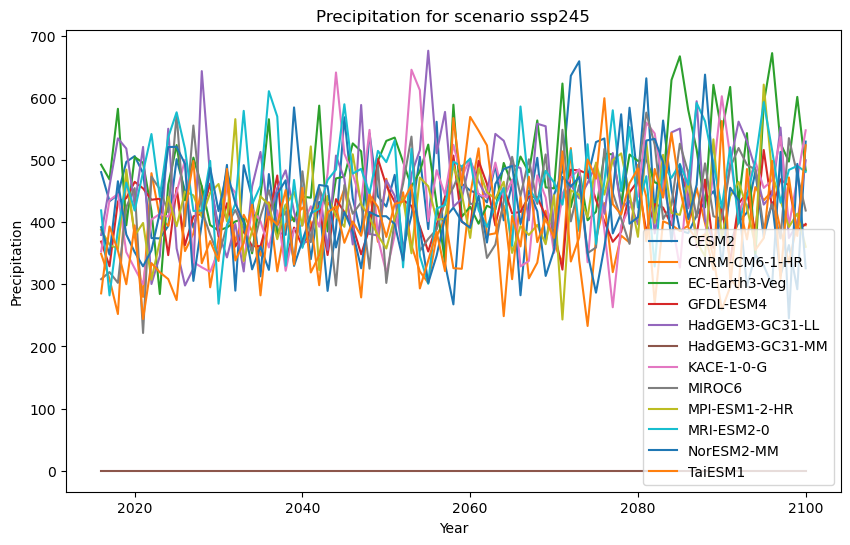

In [18]:
import matplotlib.pyplot as plt

df_ssp245 = pr_df[pr_df["scenario"] == "ssp245"][pr_df["year"] > 2015]
plt.figure(figsize=(10, 6))
for model in df_ssp245["model"].unique():
    model_data = df_ssp245[df_ssp245["model"] == model]
    plt.plot(model_data["year"], model_data["pr"], label=model)

plt.xlabel("Year")
plt.ylabel("Precipitation")
plt.title("Precipitation for scenario ssp245")
plt.legend()
plt.show()

### Temperature

Now, do the same as above for temperature!

In [126]:
tas_wcps_query = wcps_query.format(
    cov_id="cmip6_monthly_air_temperature", wkt_latlon_str=wkt_latlon_str
)
tas_wcps_query = urllib.parse.quote_plus(tas_wcps_query).replace("+", "%20")

url = base_wcps_url.format(wcps_query=tas_wcps_query)
r = requests.get(url)

tas_ds = xr.open_dataset(io.BytesIO(r.content))

# can re-use the timeseries array
tas_ds = tas_ds.assign_coords(t=ts).rename(t="time", band1="tas")

tas_ds = tas_ds.assign_coords(
    model=[model_lu[np.floor(m)] for m in tas_ds.model.values],
    scenario=[scenario_lu[np.floor(s)] for s in tas_ds.scenario.values],
    # also convert the time to a noleap calendar as it will make time-based subsetting easier
).convert_calendar("noleap", align_on="year")

tas_df = (
    tas_ds.groupby("time.year")
    .apply(lambda x: x.sel(time=x.time.dt.month.isin([5, 6, 7, 8, 9])).mean(dim="time"))
    .to_dataframe()
)
tas_df = tas_df.reset_index()
tas_df

,year,model,scenario,tas
0,1980,CESM2,historical,7.090102
1,1980,CESM2,ssp126,NaN
2,1980,CESM2,ssp245,NaN
3,1980,CESM2,ssp370,NaN
4,1980,CESM2,ssp585,NaN
...,...,...,...,...
7255,2100,TaiESM1,historical,NaN
7256,2100,TaiESM1,ssp126,13.228299
7257,2100,TaiESM1,ssp245,12.978854
7258,2100,TaiESM1,ssp370,14.688887


## QC

Here we'll do a little quality control on the data. 
Using some of the raw data files which were ingested into Rasdaman, we will just spot check some of the processing. 

Open a single monthly file, and mask off everything but the pixels within the polygon of interest for a single time slice. Verify that this looks correct:

Text(0.5, 1.0, 'Masked DataArray with Polygon')

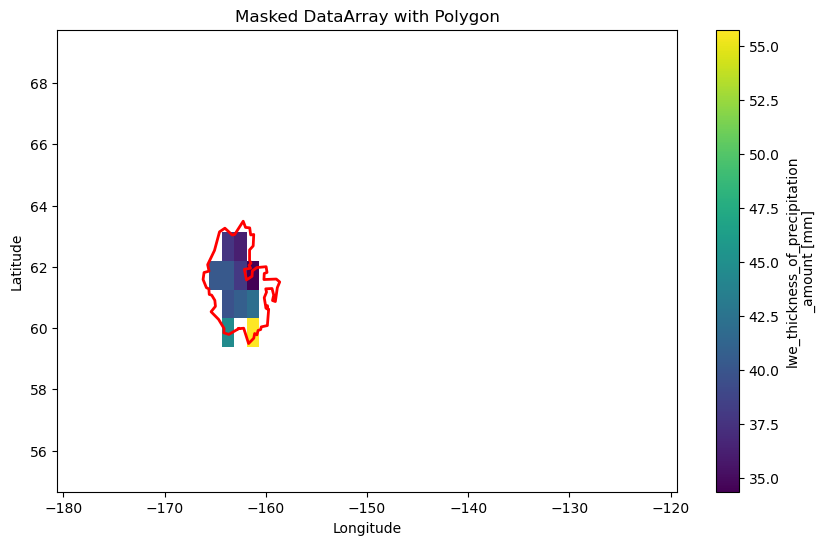

In [111]:
import rioxarray

tmp_ds = xr.open_dataset("pr_Amon_CESM2_historical.nc")
# CRS-ify the dataset
tmp_ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
tmp_ds = tmp_ds.rio.write_crs(4326)
# transpose for intuition
tmp_ds = tmp_ds.transpose("time", "lat", "lon")
# get the mask
mask = rasterio.features.geometry_mask(
    [yk_poly_4326],
    out_shape=tmp_ds.pr.shape[1:],
    transform=tmp_ds.rio.transform(),
    invert=True,
)

fig, ax = plt.subplots(figsize=(10, 6))
tmp_ds.pr.sel(time="1980-01-15").squeeze().where(mask).sel(
    lon=slice(-180, -120), lat=slice(70, 55)
).plot(x="lon", ax=ax, label="Masked DataArray")

x, y = yk_poly_4326.exterior.xy
ax.plot(x, y, color="red", linewidth=2, label="Polygon")


ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Masked DataArray with Polygon")

Yep, looks like a pixel is kept if the center point is within the polyon.

Now, we want to mask the time slices of interest and summarize. Let's do 1980-05 through 1980-09 (May - September). We will average within the non-masked data, and sum over the months to get our "truth" value for 1980 precipitaiton, for CESM2. 

In [107]:
pr_accum = []
for i in range(5):
    pr_accum.append(
        np.nanmean(
            tmp_ds.pr.transpose("time", "lat", "lon")
            .sel(time=f"1980-0{5 + i}-15")
            .squeeze()
            .where(mask)
            .values
        )
    )
np.sum(pr_accum)

441.7495292706669

Well, this looks very close to the value returned in our WCPS query:

In [122]:
pr_df.query("year == 1980 & scenario == 'historical' & model == 'CESM2'")

,year,model,scenario,pr
0,1980,CESM2,historical,440.73894


It's off by about 1mm. This is probably just due to slight differences in rounding or something, but we should do a bit more to confirm things are close enough between the two methods. 

First, we can confirm the it is not due to a "all touched" option in the mask creation:

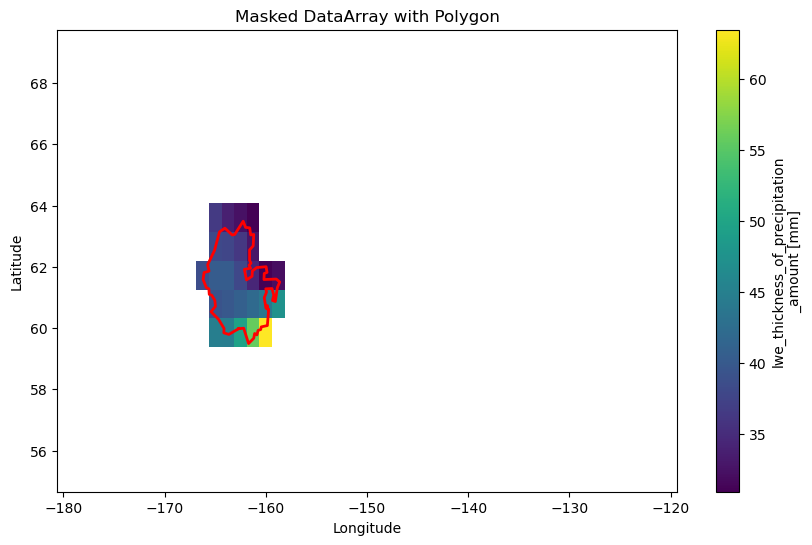

Resulting accumulated precipitation using all-touched option:  434.8474921154915


In [128]:
mask = rasterio.features.geometry_mask(
    [yk_poly_4326],
    out_shape=tmp_ds.pr.shape[1:],
    transform=tmp_ds.rio.transform(),
    invert=True,
    all_touched=True,
)

fig, ax = plt.subplots(figsize=(10, 6))
tmp_ds.pr.transpose("time", "lat", "lon").sel(time="1980-01-15").squeeze().where(
    mask
).sel(lon=slice(-180, -120), lat=slice(70, 55)).plot(
    x="lon", ax=ax, label="Masked DataArray"
)

x, y = yk_poly_4326.exterior.xy
ax.plot(x, y, color="red", linewidth=2, label="Polygon")


ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Masked DataArray with Polygon")
plt.show()

pr_accum = []
for i in range(5):
    pr_accum.append(
        np.nanmean(
            tmp_ds.pr.transpose("time", "lat", "lon")
            .sel(time=f"1980-0{5 + i}-15")
            .squeeze()
            .where(mask)
            .values
        )
    )

result = np.sum(pr_accum)

print("Resulting accumulated precipitation using all-touched option: ", result)

So we will use the original mask:

In [129]:
mask = rasterio.features.geometry_mask(
    [yk_poly_4326],
    out_shape=tmp_ds.pr.shape[1:],
    transform=tmp_ds.rio.transform(),
    invert=True,
)

And we will iterate over all years for the historical period:

In [134]:
rows = []
for year in range(1980, 2015):
    pr_accum = []
    for i in range(5):
        pr_accum.append(
            np.nanmean(
                tmp_ds.pr.transpose("time", "lat", "lon")
                .sel(time=f"{year}-0{5 + i}-15")
                .squeeze()
                .where(mask)
                .values
            )
        )

    result = np.sum(pr_accum)
    rows.append({"year": year, "pr": result})

Now, compare these to the results from the WCPS query. Plot a histogram of the differences:

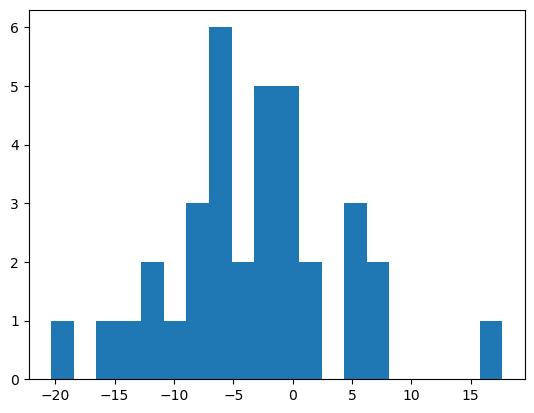

In [154]:
diffs = (
    pr_df.query("year < 2015 & scenario == 'historical' & model == 'CESM2'")[
        ["pr"]
    ].reset_index()
    - pd.DataFrame(rows)[["pr"]]
)
plt.hist(diffs["pr"], bins=20)
plt.show()

So, it looks like things are pretty close. A few summer totals are hovering around the ~5% of the overall mean total summar precip value for this model (~425 mm). 

We can have a look to see what pixels are acutally included in the WCPS query by just querying the clipping operation itself:

In [168]:
tmp_wcps = """
  for $c in (cmip6_monthly_precipitation)
    return
    encode(
        clip($c[model(0), scenario(0), ansi("1980-01-15T12:00:00.000Z")], 'POLYGON (({wkt_latlon_str}))'),
        "application/netcdf"
    )
)
""".strip().replace(
    "\n", ""
)  # just removing newlines because that's all we need to remove
tmp_wcps.format(wkt_latlon_str=wkt_latlon_str)

wcps_clip_query = urllib.parse.quote_plus(
    tmp_wcps.format(wkt_latlon_str=wkt_latlon_str)
).replace("+", "%20")

url = base_wcps_url.format(wcps_query=wcps_clip_query)
r = requests.get(url)


clip_ds = xr.open_dataset(io.BytesIO(r.content))

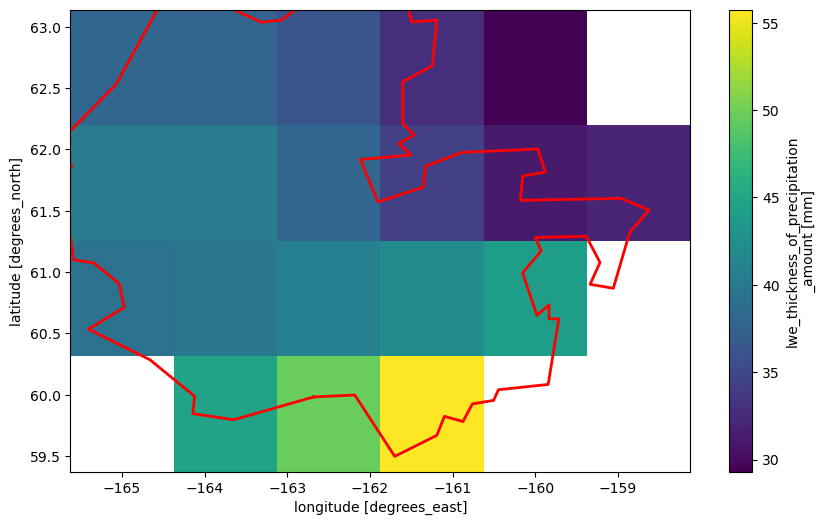

In [171]:
fig, ax = plt.subplots(figsize=(10, 6))

clip_ds.pr.transpose("lat", "lon").plot(ax=ax, label="Clipped array from Rasdaman")
ax.plot(x, y, color="red", linewidth=2, label="Polygon")

plt.show()

Interesting! It looks like the WCPS clip has included a pixel that isn't even touched by the polygon. 

In [ ]:
# reproducible poly mismatch
import numpy as np
import xarray as xr
import requests
import urllib
import io
import matplotlib.pyplot as plt
from shapely import wkt

# need h5netcdf for xarray to read the netcdf files

poly_wkt = "POLYGON ((-162.6836302045036 59.98074582942932, -163.65001804564585 59.79432082806075, -164.1442253007357 59.844663611537584, -164.12275466468824 59.98660202475141, -164.66256420183146 60.28384889426243, -165.40625076780924 60.5336745689149, -164.97547545031387 60.71073975372692, -165.03465503771562 60.90450088826059, -165.3434878223257 61.07501777495791, -165.5868226031111 61.0993243692258, -165.62518470297388 61.28005128142058, -165.8692408729038 61.31905158575416, -166.1960997291038 61.586277772083186, -166.1003531727906 61.813775498967544, -165.60877615075947 61.85844599696321, -165.74285812335148 62.070395806300155, -165.06908052006864 62.53419503985389, -164.57296020013803 63.14195568912188, -164.0414989299518 63.26108465404154, -163.31415311942928 63.038235543220665, -163.06946000939706 63.05615037850386, -162.23368368842614 63.488372478758386, -162.00179388802755 63.28625368205916, -161.5901822970316 63.27182013597678, -161.49347231085895 63.04081214887458, -161.19178559410395 63.05525913568217, -161.2467150204394 62.682358402662004, -161.6047764277912 62.55239942435296, -161.60475189479632 62.213092933095595, -161.46624335317483 62.119225294346045, -161.65524059653376 62.047732750610116, -161.50473995524118 61.955197986610585, -162.11805006168322 61.91775354481742, -161.9047445450738 61.57168837784325, -161.3585163080972 61.69213510139267, -161.32779124259233 61.86353208369644, -160.8926832011123 61.97586318501483, -159.96890198000793 62.003712302785495, -159.8801378641824 61.815986909375354, -160.1530249705406 61.783652134769746, -160.18271709413025 61.584920890826474, -158.9654470358327 61.600933103221806, -158.62662156507898 61.50579240356433, -158.8603096668933 61.3216830114306, -159.05761875676373 60.86743504497293, -159.33841993217132 60.89973304993154, -159.21849185682316 61.078027317471864, -159.38547048464358 61.291536440910534, -160.00390011843913 61.28164704581701, -159.9289393912914 61.173339795700336, -160.15531271569918 60.99280094082951, -159.9811186391756 60.646167014148155, -159.83530326373779 60.73283250724294, -159.83486615065442 60.61728333096113, -159.71729811507996 60.617285017712454, -159.84550567633292 60.08284826616574, -160.44785061516956 60.039513932616416, -160.50521839152648 59.95284530136145, -160.76257507117398 59.92395371567504, -160.87693308923346 59.77949474212826, -161.10077749241185 59.82282944968585, -161.19130236878837 59.66818000821778, -161.70173295852072 59.49584765259391, -162.18449897489498 59.996160713354485, -162.6836302045036 59.98074582942932))"
poly = wkt.loads(poly_wkt)

base_url = "https://zeus.snap.uaf.edu/rasdaman/ows?SERVICE=WCS&VERSION=2.0.1&REQUEST={request_str}"
wcps_base_str = "ProcessCoverages&QUERY={wcps_query}"
base_wcps_url = base_url.format(request_str=wcps_base_str)


# the WKT string for WCPS needs to be in (lat lon)
def flip_str(ll_str):
    lon, lat = ll_str.split(" ")
    return f"{lat} {lon}"


wkt_latlon_str = ", ".join(
    [flip_str(x) for x in poly_wkt.split("((")[1].split("))")[0].split(", ")]
)

tmp_wcps = """
  for $c in (cmip6_monthly_precipitation)
    return
    encode(
        clip($c[model(0), scenario(0), ansi("1980-01-15T12:00:00.000Z")], 'POLYGON (({wkt_latlon_str}))'),
        "application/netcdf"
    )
)
""".strip().replace(
    "\n", ""
)  # just removing newlines because that's all we need to remove
tmp_wcps.format(wkt_latlon_str=wkt_latlon_str)

wcps_clip_query = urllib.parse.quote_plus(
    tmp_wcps.format(wkt_latlon_str=wkt_latlon_str)
).replace("+", "%20")

url = base_wcps_url.format(wcps_query=wcps_clip_query)
r = requests.get(url)


clip_ds = xr.open_dataset(io.BytesIO(r.content))

# all this just to pad the array to have larger plotting view
pad_da = xr.DataArray(
    np.pad(
        clip_ds.pr.values, ((1, 1), (1, 1)), mode="constant", constant_values=np.nan
    ),
    coords={
        "lat": np.pad(
            clip_ds.pr.lat.values, (1, 1), mode="constant", constant_values=np.nan
        ),
        "lon": np.pad(
            clip_ds.pr.lon.values, (1, 1), mode="constant", constant_values=np.nan
        ),
    },
    dims=clip_ds.dims,
)
lat_res = np.diff(clip_ds["lat"])[1]
lon_res = np.diff(clip_ds["lon"])[1]
pad_da["lat"] = np.array(
    [clip_ds.lat[0].values - lat_res]
    + [x for x in clip_ds.lat.values]
    + [clip_ds.lat[-1].values + lat_res]
)
pad_da["lon"] = np.array(
    [clip_ds.lon[0].values - lon_res]
    + [x for x in clip_ds.lon.values]
    + [clip_ds.lon[-1].values + lon_res]
)

fig, ax = plt.subplots(figsize=(10, 6))

pad_da.transpose("lat", "lon").plot(ax=ax)

x, y = poly.exterior.xy
ax.plot(x, y, color="red", linewidth=2)

plt.show()

In [ ]:
# temporary cell with dim encoding stuff in case that gets fixed
desc_cov_base_str = "DescribeCoverage&COVERAGEID={cov_id}"
desc_cov_base_url = base_url.format(request_str=desc_cov_base_str)
resp = requests.get(desc_cov_base_url.format(cov_id="cmip6_monthly_precipitation"))

# new way to mess with?
import json
import xmltodict

decoded_response = resp.content.decode("utf-8")
response_json = json.loads(json.dumps(xmltodict.parse(decoded_response)))